In [1]:
import torch
from torch import nn
from torchvision.models import resnet101,ResNet101_Weights
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os 
import glob
from PIL import Image
import numpy as np
from torch.functional import F
from torchvision import datasets

In [2]:

class MyDataset(Dataset):
    def __init__(self, data_dir=r"data/VOCdevkit/VOC2012", image_size=(512,512), is_train=True, transform=None):
        super(MyDataset,self).__init__()
        self.transform = transform
        self.is_train = is_train
        self.image_size = image_size
        self.images_list, self.mask_list = self.read_data_list_from(data_dir, self.is_train)
        
        # 定义默认的Albumentations增强
        if self.transform is None:
            if self.is_train:
                self.aug = A.Compose([
                    A.Resize(512, 512),
                    A.HorizontalFlip(p=0.5),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
                    ToTensorV2()
                ], additional_targets={'mask': 'mask'})
            else:
                self.aug = A.Compose([
                    A.Resize(image_size[0], image_size[1]),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
                    ToTensorV2()
                ], additional_targets={'mask': 'mask'})
        else:
            self.aug = self.transform

    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image_path = self.images_list[index]
        mask_path = self.mask_list[index]
        
        # 读取图像和mask，转换mask中的255为-1
        image = np.array(Image.open(image_path).convert("RGB")).astype(np.float32)
        mask = np.array(Image.open(mask_path)).astype(np.int64)
        mask[mask==255]=-1  # 提前转换255为-1
        
        # 应用数据增强
        augmented = self.aug(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        return image, mask
    
    def read_data_list_from(self, root, is_train):
        if is_train ==True:
            data_dir=os.path.join(root,"ImageSets","Segmentation","train.txt")
        else:
            data_dir=os.path.join(root,"ImageSets","Segmentation","val.txt")
        fh=open(data_dir)
        images=[]
        masks=[]
        for line in fh:
            line=line.strip("\n")
            images.append(os.path.join(root,"JPEGImages",line+".jpg"))
            masks.append(os.path.join(root,"SegmentationClass",line+".png"))
                         
        return images, masks

In [3]:
train_ds=DataLoader(MyDataset(),batch_size=15,num_workers=0,shuffle=True)
val_ds=DataLoader(MyDataset(is_train=False),batch_size=15,num_workers=0)

In [4]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding):
        super().__init__()
        self.block=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding,padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self,x):
        return self.block(x)

In [5]:
# define ASPP
class ASPP(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0)
        self.atrous6=nn.Conv2d(in_channels,out_channels,dilation=6,kernel_size=3,stride=1,padding=6,padding_mode="reflect")
        self.atrous12=nn.Conv2d(in_channels,out_channels,dilation=12,kernel_size=3,stride=1,padding=12,padding_mode="reflect")
        self.atrous18=nn.Conv2d(in_channels,out_channels,dilation=18,kernel_size=3,stride=1,padding=18,padding_mode="reflect")
        self.pool=nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        conv=self.conv(x)
        atrous6=self.atrous6(x)
        atrous12=self.atrous12(x)
        atrous18=self.atrous18(x)
        pooled=self.pool(x)
        pooled=F.interpolate(
            pooled,
            size=x.shape[2:],
            mode="bilinear",
            align_corners=True
        )
        return torch.cat((conv,atrous6,atrous12,atrous18,pooled),dim=1)

In [6]:
# define DeepLabV3+
class DeepLabV3P(nn.Module):
    def __init__(self,C=21):
        super().__init__()
        backbone=resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
        for name,param in backbone.named_parameters():
            param.requires_grad = False
        self.set_dilation(backbone)
        self.lower_f=nn.Sequential(*list(backbone.children())[:5])## 256 56 56
        self.up_f0=nn.Sequential(*list(backbone.children())[5:7])
        self.up_f1=nn.Sequential(*list(backbone.children())[7])## 2048 14 14

        self.aspp=ASPP(2048,256)
        self.up_conv=ConvBlock(256*5,256,kernel_size=1,stride=1,padding=0)
        self.down_conv=ConvBlock(256,128,kernel_size=1,stride=1,padding=0)
        self.cat_conv=ConvBlock(256+128,C,kernel_size=3,stride=1,padding=1)
    def set_dilation(self,layer,d=2):
        p=d
        s=1
        for n,m in layer.named_modules():
            if n in ["layer3.1.conv2","layer3.2.conv2","layer3.3.conv2","layer3.4.conv2","layer3.5.conv2",
                     "layer3.6.conv2","layer3.7.conv2","layer3.8.conv2","layer3.9.conv2","layer3.10.conv2",
                     "layer3.11.conv2","layer3.12.conv2","layer3.13.conv2","layer3.14.conv2","layer3.15.conv2",
                     "layer3.16.conv2","layer3.17.conv2","layer3.18.conv2","layer3.19.conv2","layer3.20.conv2",
                     "layer3.21.conv2","layer3.22.conv2","layer.4.0.conv2"]:
                m.dilation=(d,d)
                m.padding=(p,p)
            elif n in ["layer3.0.conv2"]:
                m.stride=(s,s)
            elif n in ["layer3.0.downsample.0"]:
                m.stride=(s,s)
            elif n in ["layer4.1.conv2","layer4.2.conv2"]:
                m.dilation=(2*d,2*d)
                m.padding=(2*p,2*p)
    def forward(self,x):
        lower_f=self.lower_f(x)
        up_f=self.up_f0(lower_f)
        up=self.up_f1(up_f)
        aspp=self.aspp(up)
        up_out=self.up_conv(aspp)
        up_out=F.interpolate(
            up_out,
            scale_factor=4,
            mode="bilinear",
            align_corners=True
        )

        down_out=self.down_conv(lower_f)
        cat=torch.cat((up_out,down_out),dim=1)
        out=self.cat_conv(cat)
        return F.interpolate(out,scale_factor=4,mode="bilinear",align_corners=True)

In [7]:
deeplab=DeepLabV3P()

In [8]:
def miou(pred,target,num_classes=21):
    cm=np.zeros((num_classes,num_classes),dtype=np.int64)
    pred=pred.argmax(dim=1)
    y_pred_flat=pred.detach().cpu().numpy().flatten()
    y_true_flat=target.detach().cpu().numpy().flatten()
    for t,p in zip(y_true_flat,y_pred_flat):
        cm[t][p]+=1
    sum_true=np.sum(cm,axis=1)
    sum_pred=np.sum(cm,axis=0)
    tp=np.diag(cm)
    denominator=sum_true+sum_pred-tp
    iou=tp/denominator
    iou[denominator==0]=np.nan
    return np.nanmean(iou)

In [9]:
## 定义预测函数
model=DeepLabV3P()
def predict(net,data_iter,num=15,idx=2):
    checkpoint=torch.load("model_best_deeplab.pth",weights_only=True)
    load_weights=checkpoint
    weights={k[7:] if "module." in k else k :v for k,v in load_weights.items()}
    weights={k : v for k,v in weights.items() if k in net.state_dict().keys()}
    net.load_state_dict(weights)
    iters=iter(data_iter)
    for j in range(idx-1):
        next(iters)
    image,target=next(iters)
    images,targets=[],[]
    net.to(0)
    net.eval()
    with torch.no_grad():
        pred=net(image.to(0))
        iou=miou(pred,target)
        print(iou)
    for i in range(num):
        images.append(image[i].permute(1,2,0).detach().cpu())
        targets.append(target[i].detach().cpu())
    return images,targets,pred

In [10]:
def show(idx=1,is_train=True):
    if is_train:
        origin,targets,preds=predict(model,train_ds,idx=idx)
    else:
        origin,targets,preds=predict(model,val_ds,idx=idx)
    predicted=preds.argmax(1)
    preds=[predicted[i].detach().cpu() for i in range(15)]
    fig,axes=plt.subplots(3,5,figsize=(20,10))
    for i in range(3):
        for j in range(5):
            axes[i,j].imshow(origin[j+i*5])
            axes[i,j].set_xticks(())
            axes[i,j].set_yticks(())
    plt.suptitle('Original Image',fontsize=30)
    fig.tight_layout()
    plt.show()
    fig,axes=plt.subplots(3,5,figsize=(20,10))
    for i in range(3):
        for j in range(5):
            axes[i,j].imshow(targets[j+i*5])
            axes[i,j].set_xticks(())
            axes[i,j].set_yticks(())
    plt.suptitle('Target Image',fontsize=30)
    fig.tight_layout()
    plt.show()
    fig,axes=plt.subplots(3,5,figsize=(20,10))
    for i in range(3):
        for j in range(5):
            axes[i,j].imshow(preds[j+i*5])
            axes[i,j].set_xticks(())
            axes[i,j].set_yticks(())
    plt.suptitle('Predicted Image',fontsize=30)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_1338/877031662.py:12: RuntimeWarning: invalid value encountered in divide
  iou=tp/denominator
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1054919..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0810895..2.3187811].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6974427..2.62697].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1149807..2.6361494].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0177455..2.6371386].
Clipping input data to 

0.7104342415217634


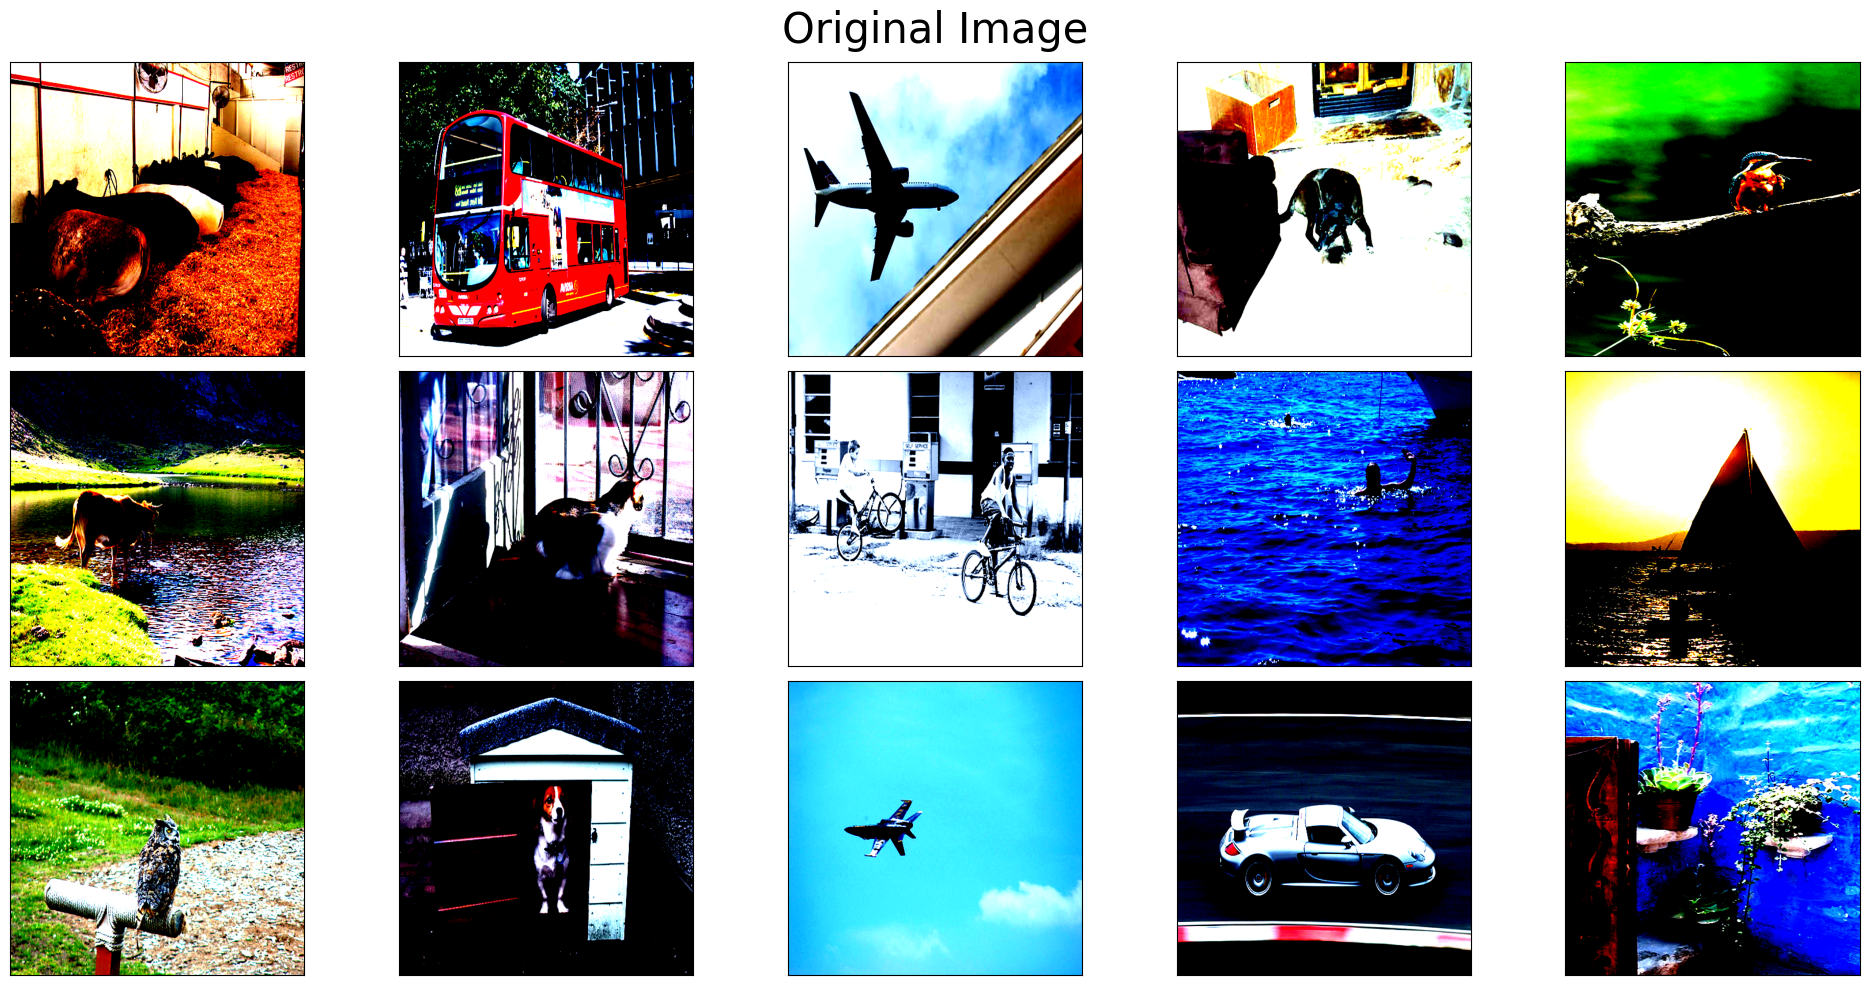

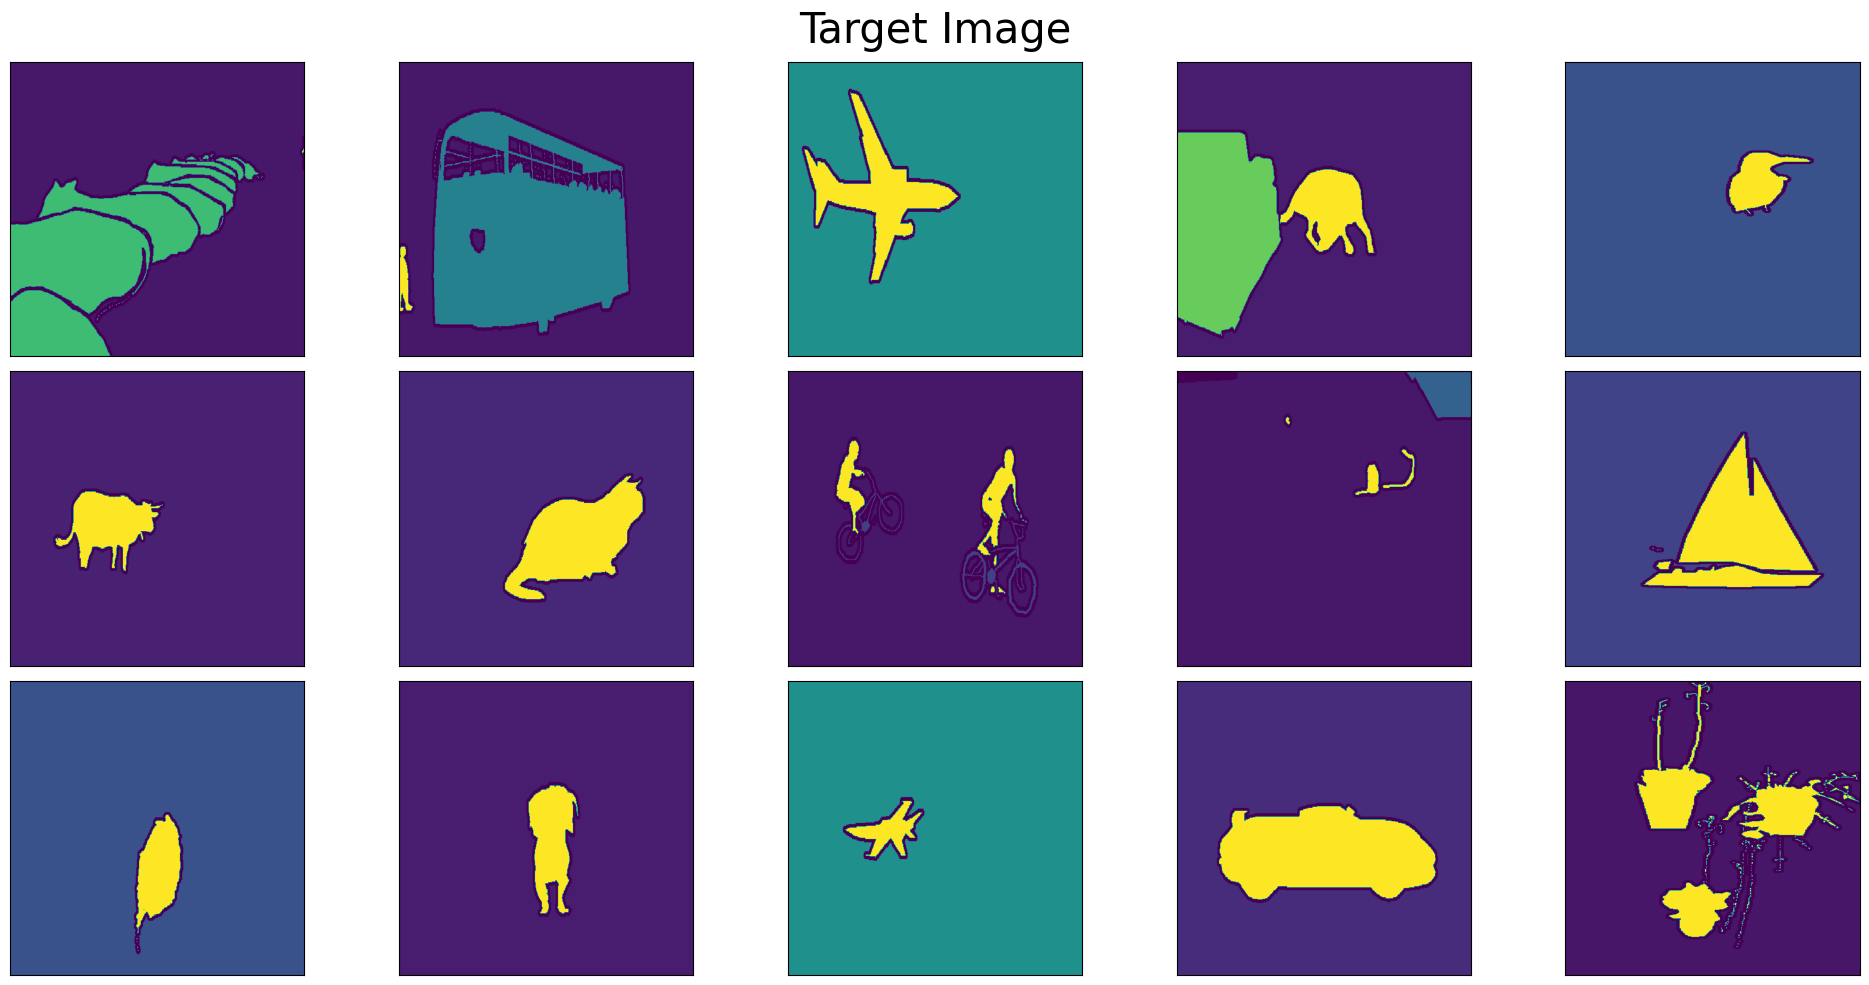

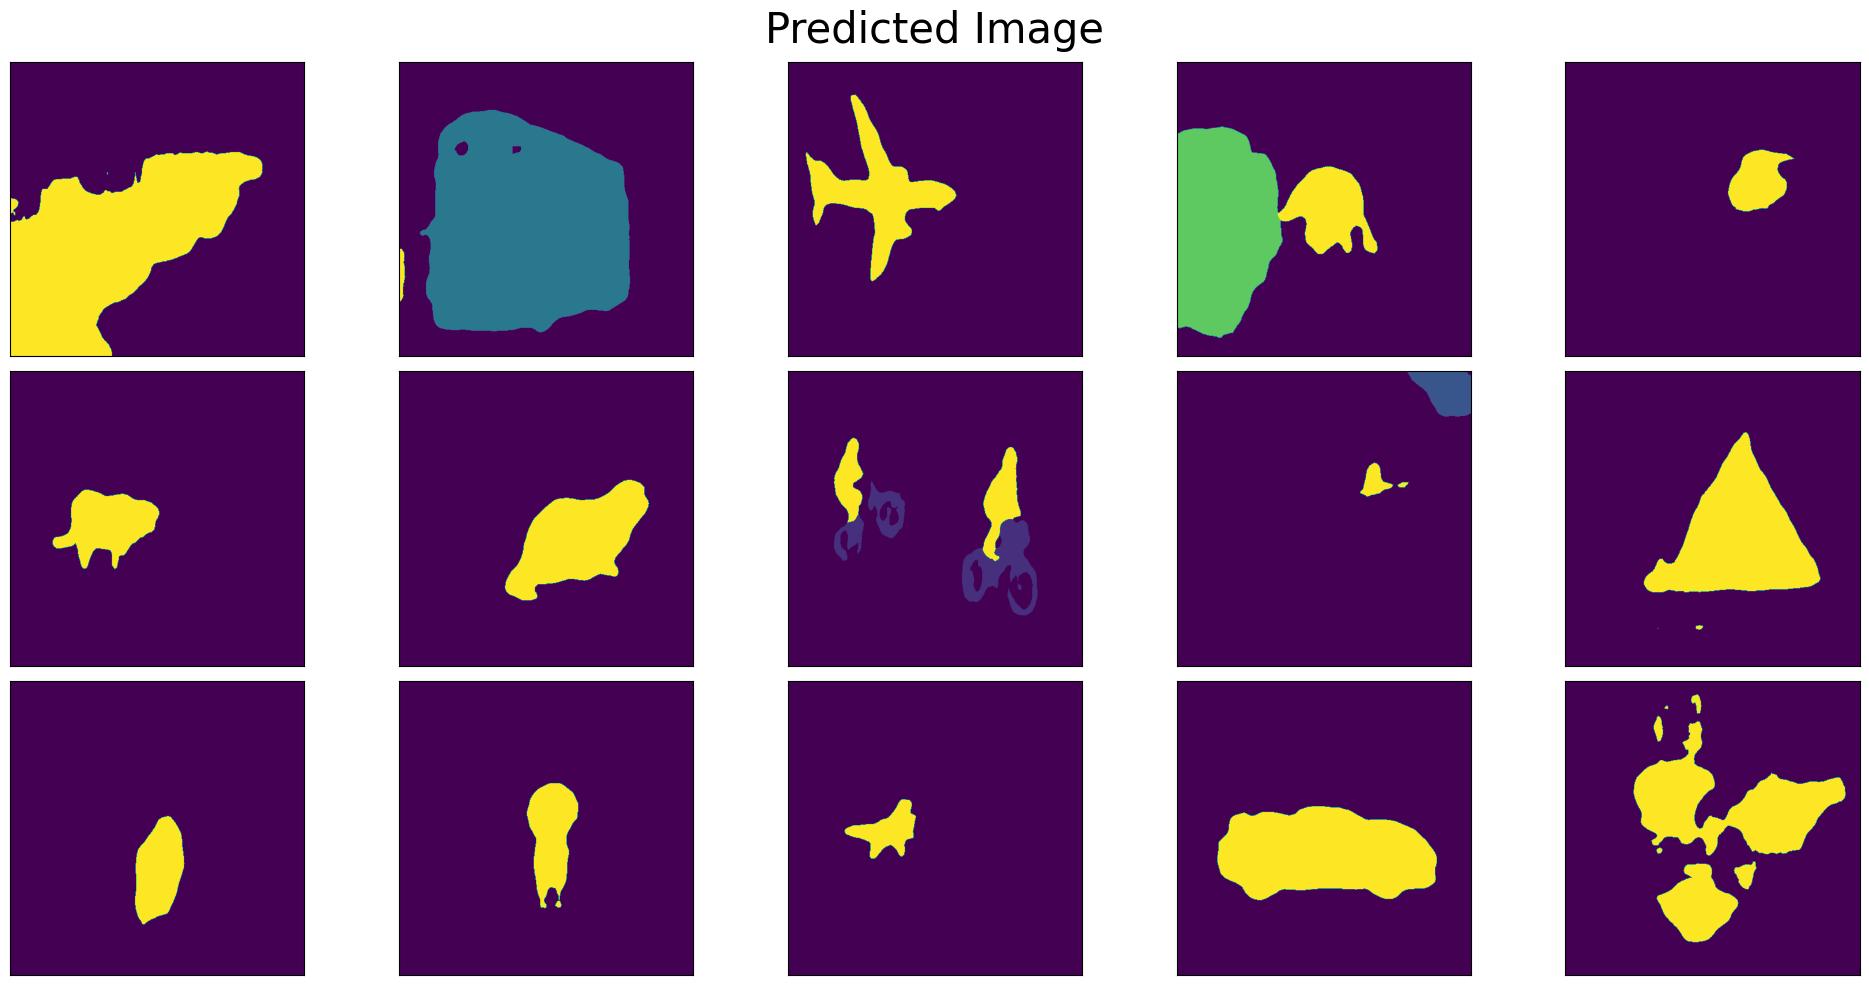

In [14]:
show(idx=3,is_train=True)

/tmp/ipykernel_1338/877031662.py:12: RuntimeWarning: invalid value encountered in divide
  iou=tp/denominator
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.631368].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1035535..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0119512..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.083704..2.2159927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0944192..2.6399999].
Clipping input data to t

0.5069716582062341


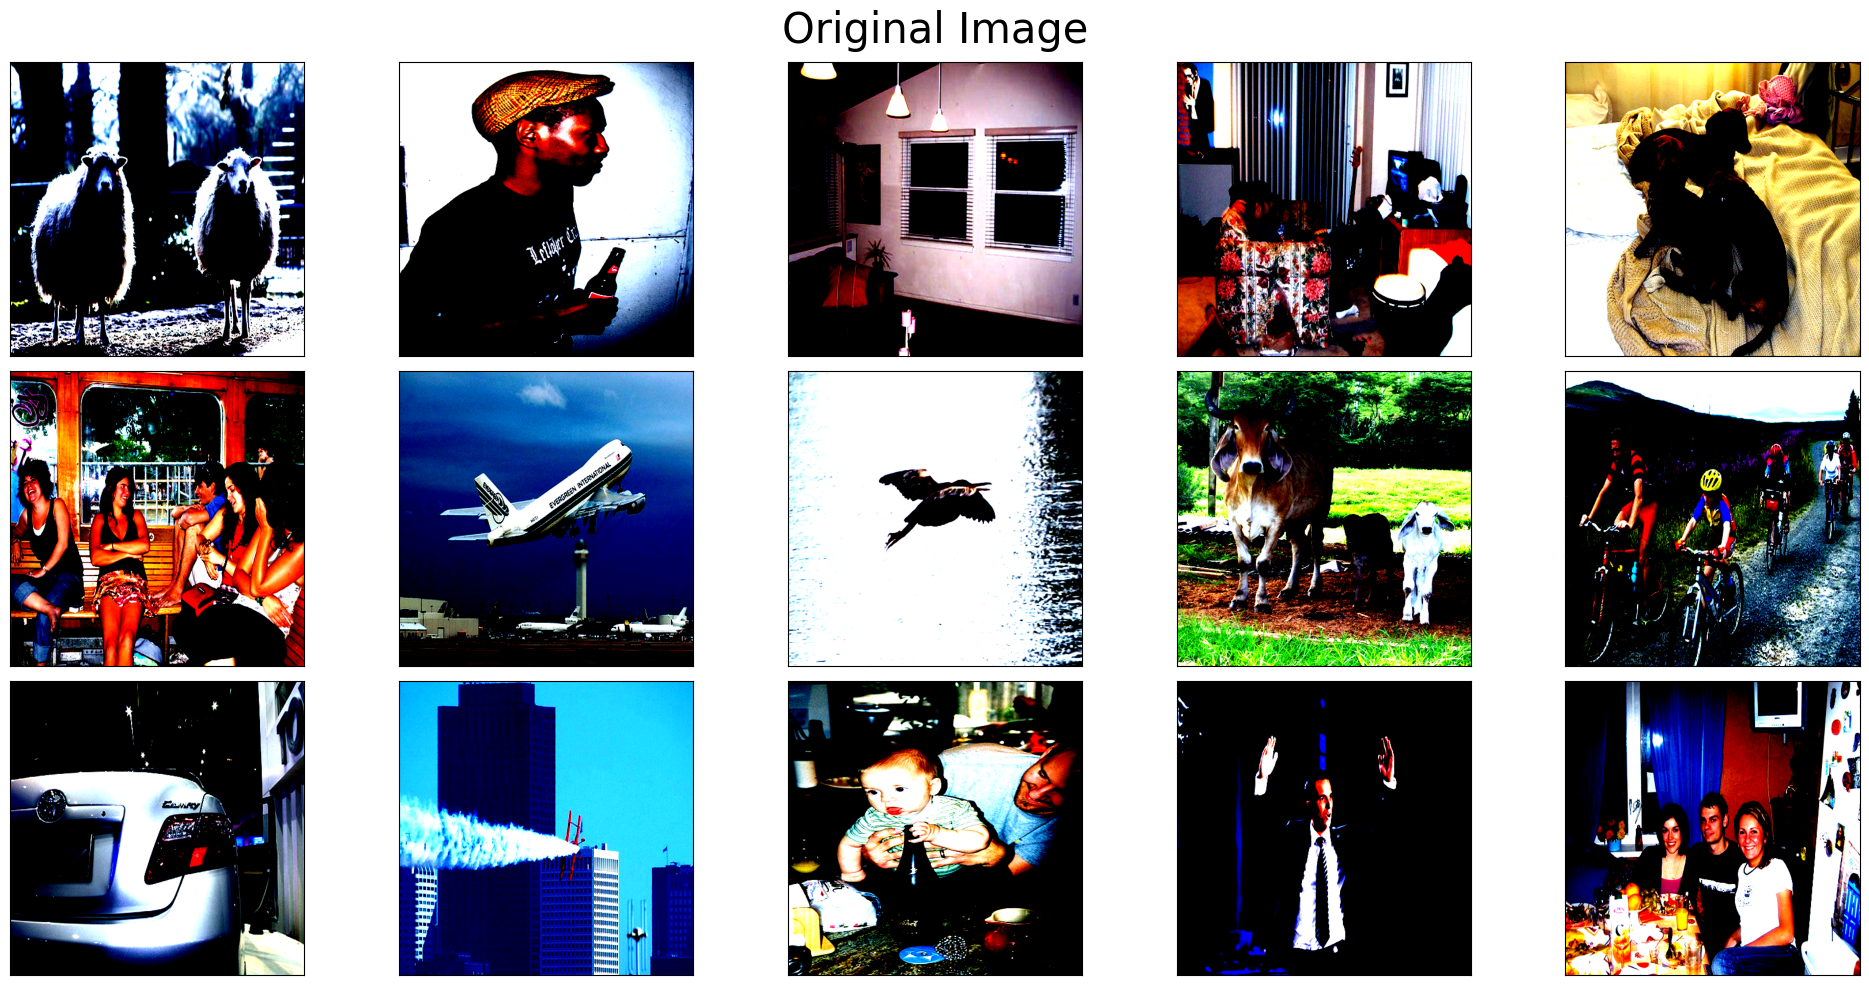

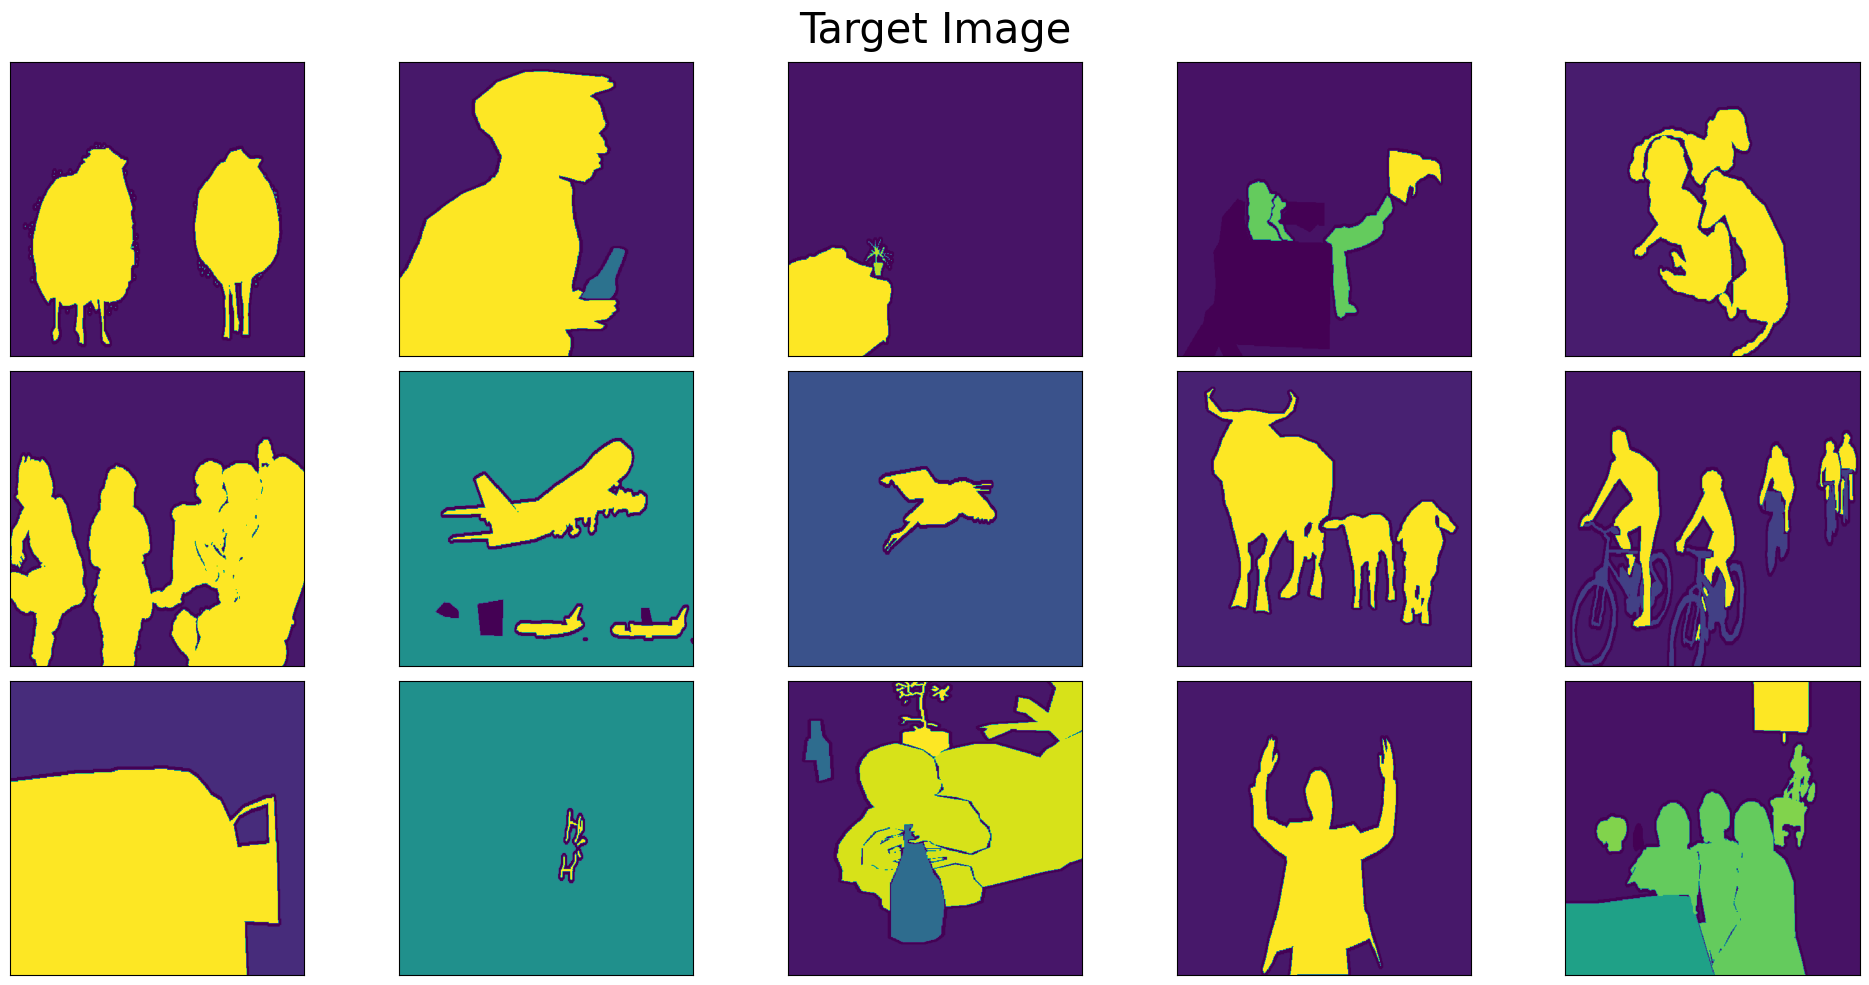

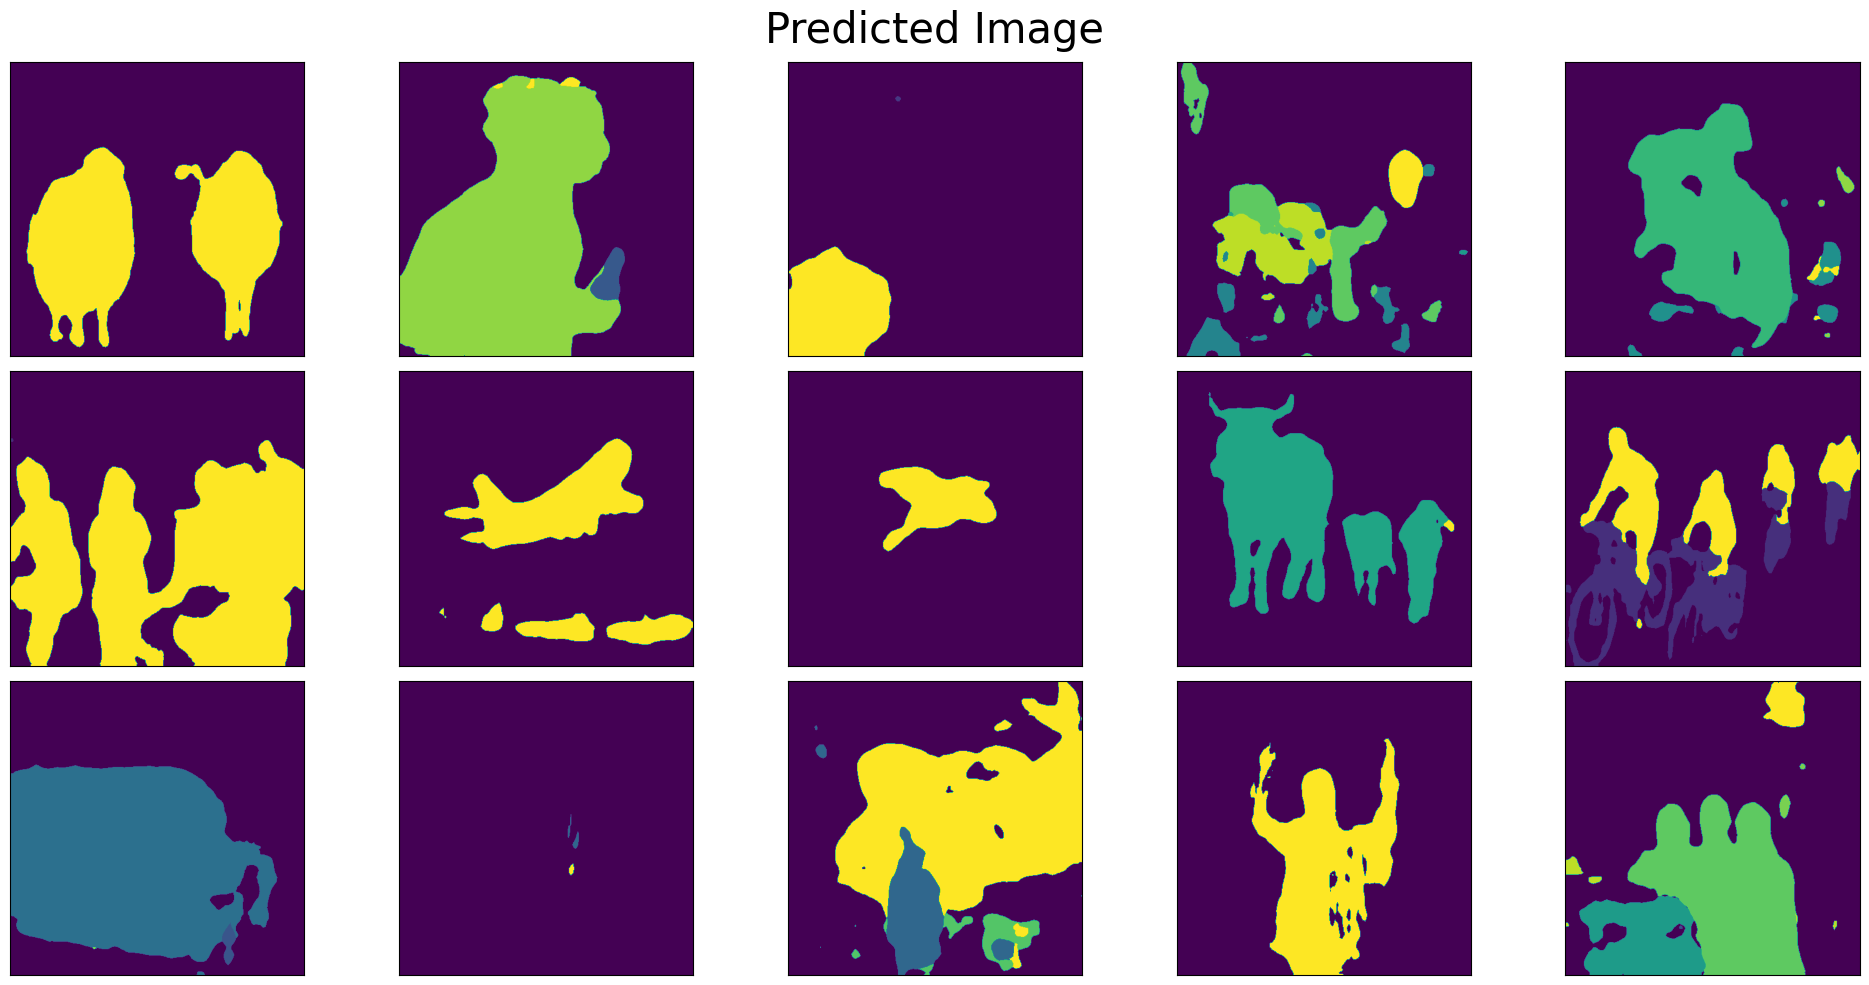

In [15]:
show(idx=3,is_train=False)

## 恭喜你训练了一个DeepLabV3+网络
### 我采用的是resnet101作为骨干网络，并在一台gpu上训练了几个小时得出的结果，效果还不错，但并未发挥出模型的全部性能
### 读者可以试着更换更加轻量级的网络，或者使用Xception作为骨干网络来对模型进行调试